In [46]:
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [47]:
torch.manual_seed(44)

In [48]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [49]:
df = pd.read_csv('fashion-mnist_train.csv')
df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [50]:
df.shape

(60000, 785)

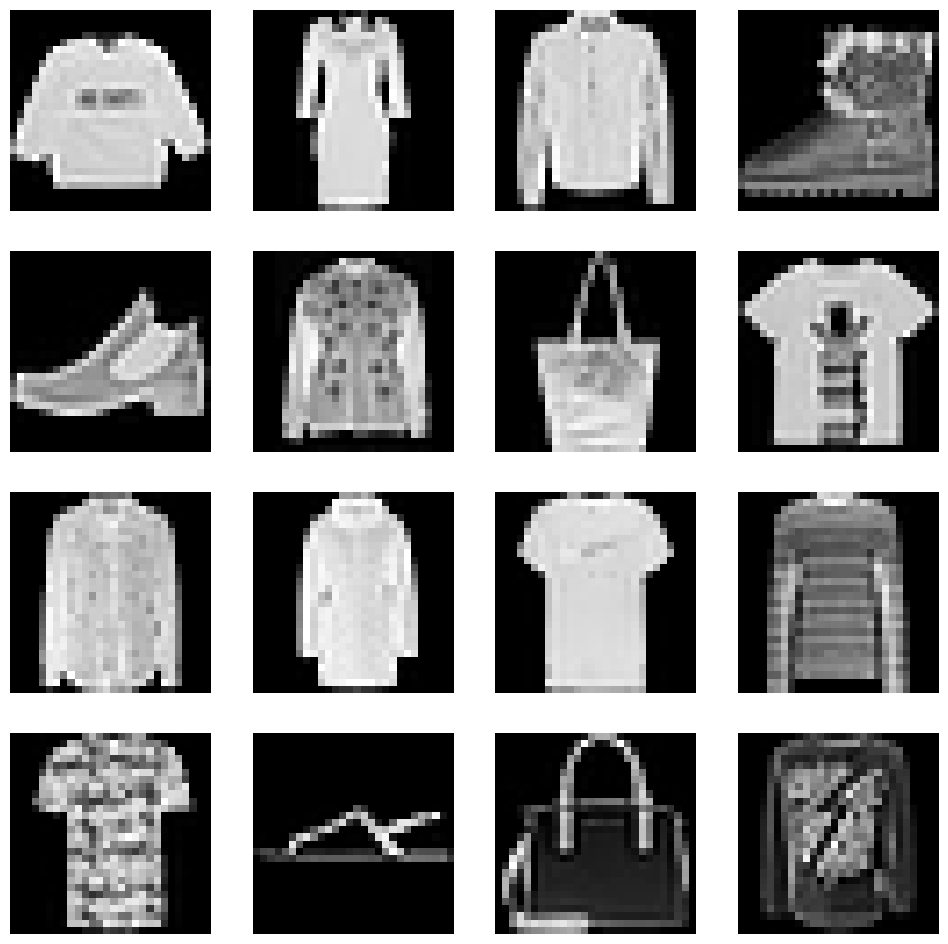

In [51]:
# Create a 4 x 4 grid of images
fig, ax = plt.subplots(4, 4, figsize=(12, 12))
for i in range(4):
    for j in range(4):
        ax[i, j].imshow(df.iloc[i + 4*j, 1:].values.reshape(28, 28), cmap='gray')
        ax[i, j].axis('off')
plt.show()

In [52]:
# Split the data into training and validation sets
X = df.iloc[:, 1:].values # features (pixels) of the images 
y = df.iloc[:, 0].values # labels (0-9) of the images

In [53]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [54]:
X_train = X_train / 255.0
X_val = X_val / 255.0

In [55]:
# Create the dataset class for the images
class CustomDataset(Dataset):

    def __init__(self, features, labels):
        self.features = torch.tensor(features, dtype=torch.float32).reshape(-1, 1, 28, 28)
        self.labels = torch.tensor(labels, dtype=torch.long)
    
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, index):
        return self.features[index], self.labels[index]

In [56]:
train_dataset = CustomDataset(X_train, y_train)
val_dataset = CustomDataset(X_val, y_val)

In [57]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True,pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False,pin_memory=True)

In [58]:
class MyNN(nn.Module):
    def __init__(self,num_features):
        super(MyNN, self).__init__()

        self.features = nn.Sequential(
                nn.Conv2d(num_features, 32, kernel_size=3, padding="same"),
                nn.ReLU(),
                nn.BatchNorm2d(32),
                nn.MaxPool2d(kernel_size=2, stride=2),
                nn.Conv2d(32, 64, kernel_size=3, padding="same"),
                nn.ReLU(),
                nn.BatchNorm2d(64),
                nn.MaxPool2d(kernel_size=2, stride=2),

        ) # Convolutional layers
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64*7*7, 128),
            nn.ReLU(),
            nn.Dropout(0.4),
            
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.4),

            nn.Linear(64, 10)
        )   # Fully connected layers
    
    def forward(self,x):
        x = self.features(x)
        x = self.classifier(x)
        return x


In [59]:
learning_rate = 0.01
epochs = 10

In [60]:
# Create model instance
model = MyNN(1)
model.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, weight_decay=0.0001)

In [61]:
# training loop

for epoch in range(epochs):
    total_epoch_loss = 0

    for batch_features,batch_labels in train_loader:
        
        # move the data to the device
        batch_features = batch_features.to(device)
        batch_labels = batch_labels.to(device)

        #foraward pass
        outputs = model(batch_features)

        #calculate the loss
        loss = criterion(outputs, batch_labels)

        #backward pass
        optimizer.zero_grad()
        loss.backward()
        
        #update the weights
        optimizer.step()

        total_epoch_loss += loss.item()
    
    avg_epoch_loss = total_epoch_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_epoch_loss:.4f}")



Epoch 1/10, Loss: 0.6660
Epoch 2/10, Loss: 0.3840
Epoch 3/10, Loss: 0.3279
Epoch 4/10, Loss: 0.2927
Epoch 5/10, Loss: 0.2693
Epoch 6/10, Loss: 0.2523
Epoch 7/10, Loss: 0.2295
Epoch 8/10, Loss: 0.2202
Epoch 9/10, Loss: 0.2035
Epoch 10/10, Loss: 0.1917


In [62]:
model.eval()

MyNN(
  (features): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (5): ReLU()
    (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=3136, out_features=128, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): ReLU()
    (6): Dropout(p=0.4, inplace=False)
    (7): Linear(in_features=64, out_features=10, bias=True)
  )
)

In [63]:
# evaluation on test data
total = 0
correct = 0

with torch.no_grad():

    for batch_features,batch_labels in val_loader:
        
        batch_features = batch_features.to(device)
        batch_labels = batch_labels.to(device)

        outputs = model(batch_features)
        _, predicted = torch.max(outputs, 1)
        
        total += batch_labels.size(0)
        correct += (predicted == batch_labels).sum().item()

print(f"Accuracy: {correct/total * 100:.2f}%")

Accuracy: 91.72%
